#**Chạy mô hình tấn công Deep Leakage Gradient (DLG)**
####SRC: *https://github.com/mit-han-lab/dlg*
####Nhóm : Coconerds
#### Thành viên nhóm:

*   Phan Thành Công - 22520170
*   Trần Vũ Bão - 22520124
*   Phan Thị Thủy Hiền - 22520423
*   Nguyễn Đỗ Đức Minh - 22520872

### Utils Script

In [ ]:
import torch
import torch.nn.functional as F


def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

### Model Script

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

### Model Training Libs

In [ ]:
import argparse
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

import numpy as np
import seaborn as sns
from itertools import product

print(torch.__version__, torchvision.__version__)


2.5.1+cu121 0.20.1+cu121


### Mount dataset + prepare input image



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(-0.5, 31.5, 31.5, -0.5)

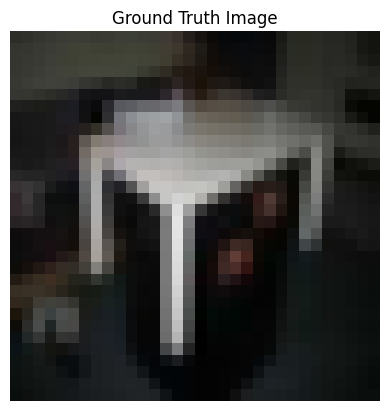

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/datasets/IS353/"
dst = datasets.CIFAR100(data_path, download=False)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

img_index = 25
gt_data = tp(dst[img_index][0]).to(device)

custom_image = None
if custom_image is not None:
    gt_data = Image.open(custom_image)
    gt_data = tp(gt_data).to(device)


gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

# Displays info
dst

plt.figure(1)
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground Truth Image")
plt.axis('off')

### Training Script - Stock Parameters Used
#### Chạy mô hình với các tham số gốc theo như bài báo DLG:
* Learning rate: 1.0
* Image Index: 25
* Epochs: 300


- Mục tiêu của kỹ thuật này là tái tạo lại dữ liệu gốc từ một mạng nơ-ron sâu bằng cách sử dụng gradient.
- Cụ thể, nó tái tạo dữ liệu đầu vào từ thông tin gradient ban đầu được tạo trong quá trình huấn luyện.
- by (chat-gpt)

Running on cuda
Training for 300 epochs...
0 107.5699
10 3.9964
20 0.4488
30 0.0522
40 0.0088
50 0.0018
60 0.0004
70 0.0001
80 0.0000
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000
299 0.0000


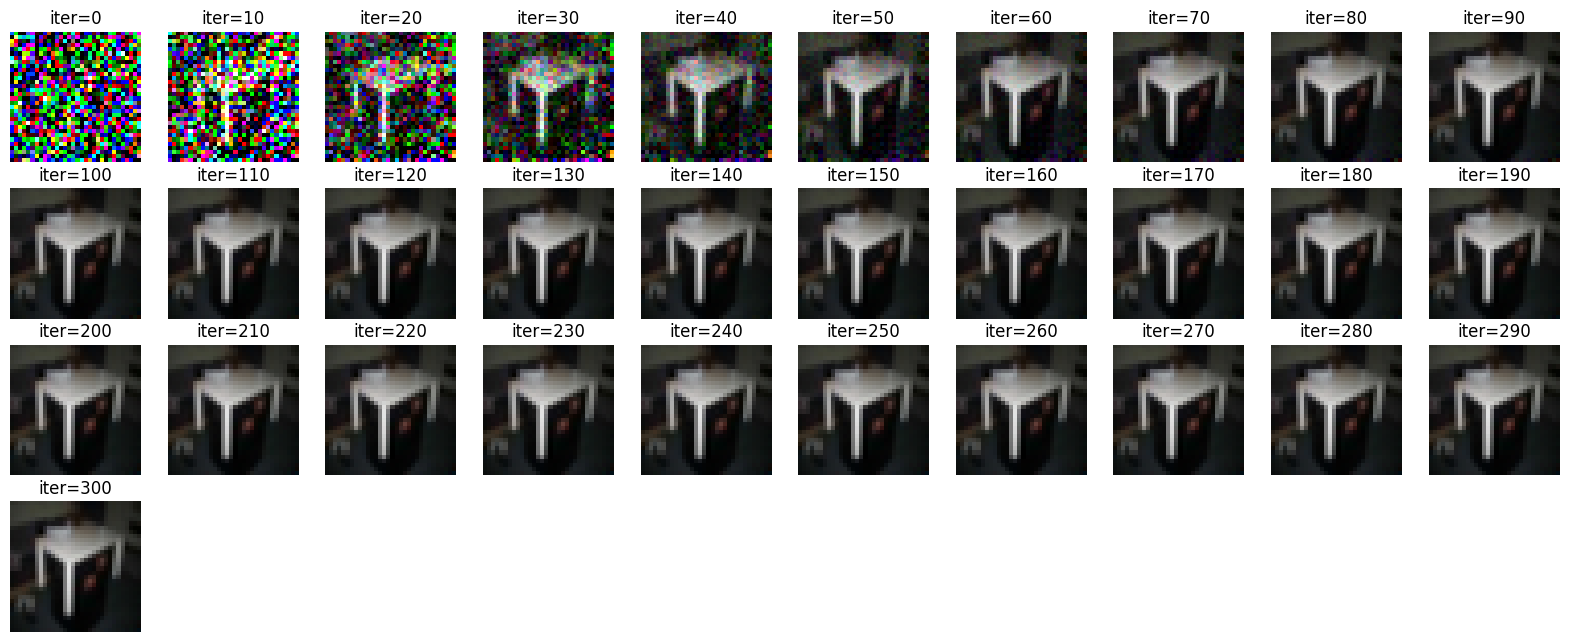

In [ ]:
# -*- coding: utf-8 -*-

# Training args
class Args:
    image = ""
    epochs = 300
    lr = 1.0

args = Args()
args

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

custom_image = None
if custom_image is not None:
    gt_data = Image.open(custom_image)
    gt_data = tp(gt_data).to(device)

print("Running on %s" % device)
epochs = int(args.epochs)
print("Training for %d epochs..." % epochs)

net = LeNet().to(device)
torch.manual_seed(1234)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

# compute original gradient
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))


# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=args.lr)

history = []
for iters in range(epochs):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0 or iters == epochs - 1:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        # Create a copy of the current dummy_data state
        current_dummy = dummy_data.detach().clone()
        # Ensure values are in valid range for visualization
        current_dummy = torch.clamp(current_dummy, 0, 1)
        history.append(tt(current_dummy[0].cpu()))

plt.figure(figsize=(20, 20))
for i in range(min(100, len(history))):
    plt.subplot(10, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.savefig('stock_output_images.png', dpi=300, bbox_inches='tight')
plt.show()


# Áp dụng kỹ thuật Grid Search để tìm ra tham số cho model có Loss thấp nhất

Training with params: lr=0.001, 100 epochs
Running on cuda
Training for 100 epochs...
Final loss before training = inf
0 442.1876
10 343.2358
20 174.1113
30 131.2212
40 98.4260
50 60.9252
60 34.9637
70 20.3826
80 13.8312
90 9.6978
Final loss after training = 6.813069820404053
Training with params: lr=0.001, 300 epochs
Running on cuda
Training for 300 epochs...
Final loss before training = inf
0 442.1871
10 343.2207
20 172.3208
30 129.7858
40 97.6515
50 59.2616
60 33.9384
70 19.8002
80 13.1576
90 9.0814
100 6.3954
110 4.6498
120 3.4134
130 2.5268
140 1.8624
150 1.3061
160 0.9013
170 0.5808
180 0.3998
190 0.2712
200 0.1946
210 0.1526
220 0.1225
230 0.1003
240 0.0846
250 0.0726
260 0.0634
270 0.0562
280 0.0503
290 0.0452
Final loss after training = 0.0408770851790905
Training with params: lr=0.001, 500 epochs
Running on cuda
Training for 500 epochs...
Final loss before training = inf
0 442.1863
10 343.2292
20 180.9236
30 132.4966
40 101.3235
50 67.2073
60 39.0349
70 22.8213
90 10.0148
100

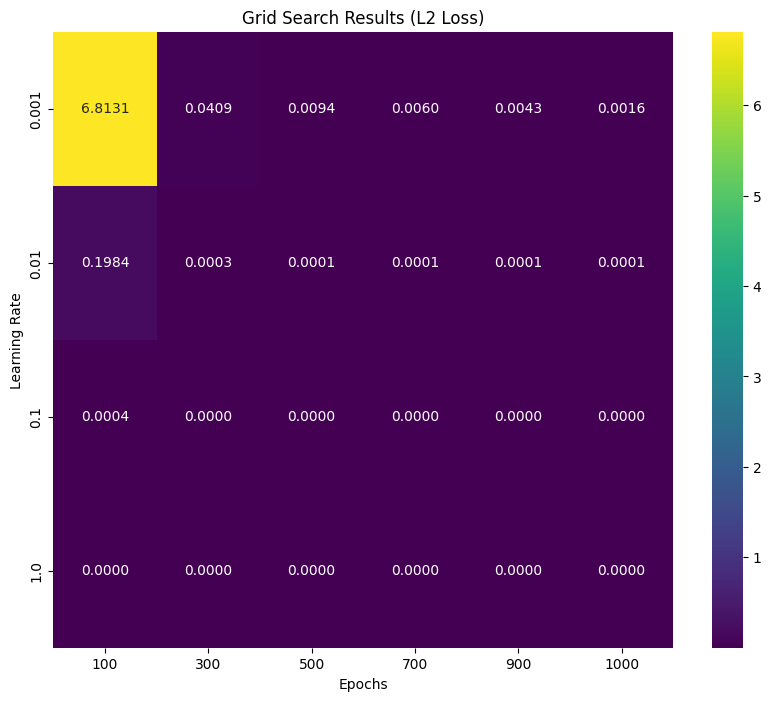

Best parameters: lr=1.0, epochs=900
Best L2 loss: 0.0000


In [ ]:
# Define parameter grids
learning_rates = [0.001, 0.01, 0.1, 1.0]
# learning_rates = [0.001, 0.01]
epoch_values = [100, 300, 500, 700, 900, 1000]

# Function to run training and return final loss
def train_model(lr, num_epochs):
    # Init network
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    print("Running on %s" % device)
    print("Training for %d epochs..." % epochs)
    net = LeNet().to(device)

    # Reset model
    net.apply(weights_init)
    torch.manual_seed(1234)

    criterion = cross_entropy_for_onehot

    pred = net(gt_data)
    y = criterion(pred, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    # Initialize optimizer with current lr
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=lr)

    final_loss = float('inf')
    print(f'Final loss before training = {final_loss}')
    for iters in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            dummy_pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(dummy_pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)
        current_loss = closure()
        if iters % 10 == 0:
            print(iters, "%.4f" % current_loss.item())
        elif iters == num_epochs - 1:
            final_loss = current_loss.item()
            print(f'Final loss after training = {final_loss}')

    return final_loss

# Perform grid search
results = np.zeros((len(learning_rates), len(epoch_values)))
best_loss = float('inf')
best_params = None

# Training loop
for i, lr in enumerate(learning_rates):
    for j, epochs in enumerate(epoch_values):
        print(f'Training with params: lr={lr}, {epochs} epochs')
        loss = train_model(lr, epochs)
        results[i, j] = loss
        if loss < best_loss:
            best_loss = loss
            best_params = (lr, epochs)

# Visualize results
plt.figure(figsize=(10, 8))
sns.heatmap(results,
            xticklabels=epoch_values,
            yticklabels=learning_rates,
            annot=True,
            fmt='.4f',
            cmap='viridis')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Grid Search Results (L2 Loss)')
plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best parameters: lr={best_params[0]}, epochs={best_params[1]}")
print(f"Best L2 loss: {best_loss:.4f}")

------------------------------------------------------------------------
- Note: code này chạy để tìm siêu tham số tốt nhất để thực hiện kỹ thuật tấn công
- từ code trên ta suy ra đc

=> Final loss after training = 1.1732877283066045e-06

Best parameters:

lr=1.0

epochs=900

Best L2 loss: 0.0000

** nhưng mình chỉ chạy 300 epochs chứ không phải 900 **



### Trực quan hóa DLG L2 Loss trên biểu đồ đường
####Tham số sử dụng - các tham số tốt nhất cho model đã tìm được thông qua Grid Search:
- Epochs: 300
- Learning rate: 1.0
- Optimizer: LBFGS

In [1]:
# -*- coding: utf-8 -*-
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Training args
class Args:
    image = ""
    epochs = 300
    lr = 1.0

args = Args()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

print("Running on %s" % device)
epochs = int(args.epochs)
print("Training for %d epochs..." % epochs)

net = LeNet().to(device)
torch.manual_seed(1234)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

# compute original gradient
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=args.lr)

image_history = []
epoch_points = []
loss_history = []
for iters in range(epochs):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0 or iters == epochs - 1:
        current_loss = closure()
        print(iters + 1, f': {current_loss.item()}')
        # Create a copy of the current dummy_data state
        current_dummy = dummy_data.detach().clone()

        # Store loss and epoch number
        loss_history.append(current_loss.item())
        epoch_points.append(iters)

        # Ensure values are in valid range for visualization
        current_dummy = torch.clamp(current_dummy, 0, 1)
        image_history.append(tt(current_dummy[0].cpu()))

# Create visualization with images and loss values
fig, ax = plt.subplots(figsize=(25, 12))

# Plot loss curve 
ax.plot(epoch_points, loss_history, 'b-', linewidth=2, zorder=1)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('L2 Loss', fontsize=12)
ax.set_title('Epoch - loss progress', fontsize=14)

# Set logarithmic scale
ax.set_yscale('log')
ax.set_ylim(1e-6, max(loss_history))
ax.grid(True, alpha=0.3)

# Add images and loss values
for x, y, img in zip(epoch_points, loss_history, image_history):
    # Add image
    imagebox = OffsetImage(np.array(img),
                          zoom=0.8,
                          resample=True)
    
    ab_img = AnnotationBbox(imagebox, (x, y),
                           xybox=(0, 40),
                           xycoords='data',
                           boxcoords="offset points",
                           frameon=True,
                           bboxprops=dict(facecolor='white',
                                        edgecolor='gray',
                                        alpha=0.9))
    ax.add_artist(ab_img)

    # Add loss value text below image 
    ax.annotate(f'{y:.2e}',  # Scientific notation
                xy=(x, y),
                xytext=(0, -20),  # Position below point
                textcoords='offset points',
                ha='center',
                va='top',
                bbox=dict(facecolor='white',
                         edgecolor='none',
                         alpha=0.7))

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'torch' is not defined